<!--
# 📰 NLP Project: News Classification & Analysis (CNN)

## Objectif du notebook
Ce notebook présente :
- La préparation des données textuelles
- La visualisation (nuages de mots, performances)
- L'entraînement d’un modèle CNN
- L’évaluation (accuracy & loss)
- La sauvegarde et le téléchargement du modèle

Notebook structuré, lisible et commenté. -->



## 0. Importation des bibliothèques


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

## 1. Données de fusion :
##### Notre ensemble de données est basé sur le fichier csv d'origine, la structure du mème incluant également les fusionnés pour créer cet ensemble de données.

In [ ]:
data = pd.read_csv("archive/CNN_Articels_clean.csv")
data2 = pd.read_csv("archive/CNN_Articels_clean2.csv")

# Fusionner les deux DataFrames (concaténer verticalement)
df_merged = pd.concat([data, data2], ignore_index=True)

# Sauvegarder le résultat dans un nouveau fichier CSV
df_merged.to_csv('fusion_data1.csv', index=False)

print(f"Fusion terminée ! Nombre total de lignes : {len(df_merged)}")


## 2. Chargement du corpus


##### fusion_data1.csv est la fusion des deux fichiers csv

In [ ]:
# Exemple de chargement
data_complete = pd.read_csv("fusion_data1.csv")  # colonnes: text, category
data_complete.head()


,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,2,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,3,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,4,"Paul R. La Monica, CNN Business",2022-03-15 09:57:36,business,investing,https://www.cnn.com/2022/03/15/investing/brics...,Russia is no longer an option for investors. T...,"For many years, the world's most popular emerg...","investing, Russia is no longer an option for i...",Russia is no longer an option for investors. T...,"New York (CNN Business)For many years, the wor..."
4,7,Reuters,2022-03-15 11:27:02,business,business,https://www.cnn.com/2022/03/15/business/russia...,Russian energy investment ban part of new EU s...,The European Union formally approved on Tuesda...,"business, Russian energy investment ban part o...",EU bans investment in Russian energy in new sa...,The European Union formally approved on Tuesda...


# 3. Pour notre modele on besoin seulement de Article text et Category

In [5]:
data = data_complete[['Article text', 'Category']]

# 4. Suppresion des valeurs manquantes

In [6]:
# Compter les valeurs manquantes par colonne
print("=== Nombre de valeurs manquantes par colonne ===")
print(data.isnull().sum())

=== Nombre de valeurs manquantes par colonne ===
Article text    9
Category        0
dtype: int64


In [7]:
# Supprimer les lignes avec NaN
data = data.dropna(subset=['Article text'])

In [8]:
# Compter les valeurs manquantes par colonne
print("=== Nombre de valeurs manquantes par colonne ===")
print(data.isnull().sum())

=== Nombre de valeurs manquantes par colonne ===
Article text    0
Category        0
dtype: int64



## 4. Visualisation : Nuages de mots par catégorie


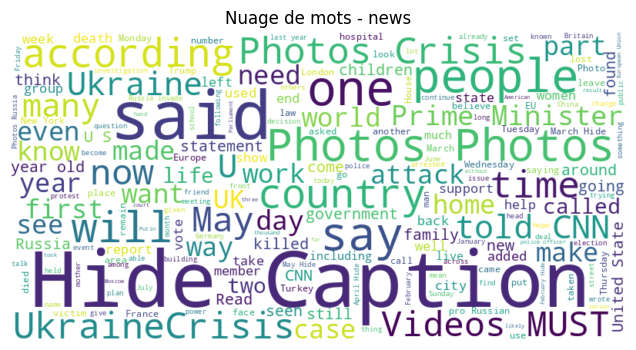

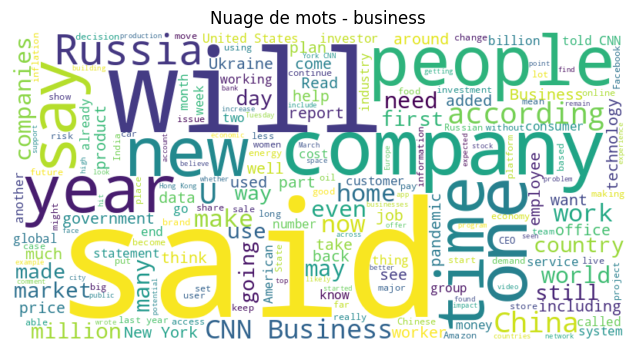

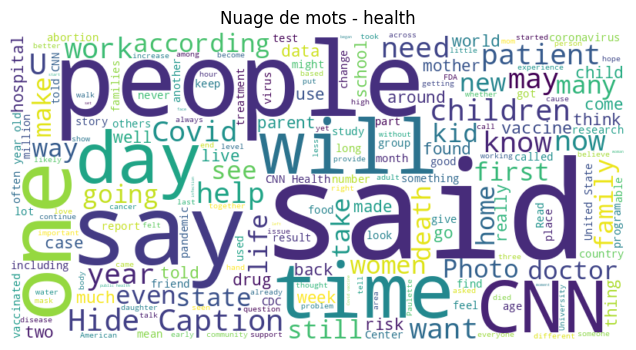

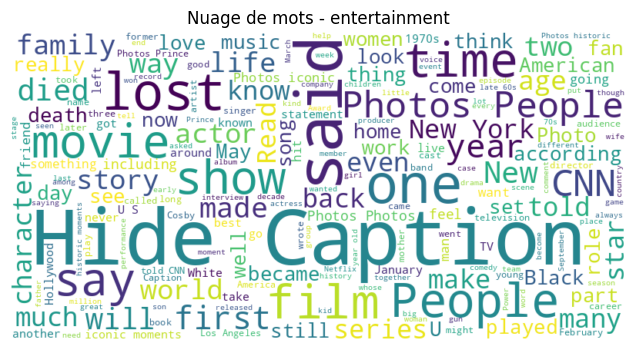

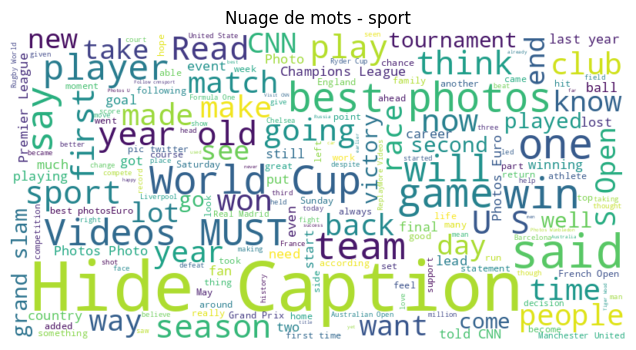

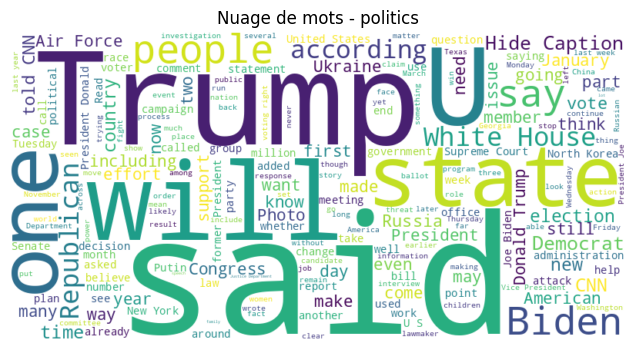

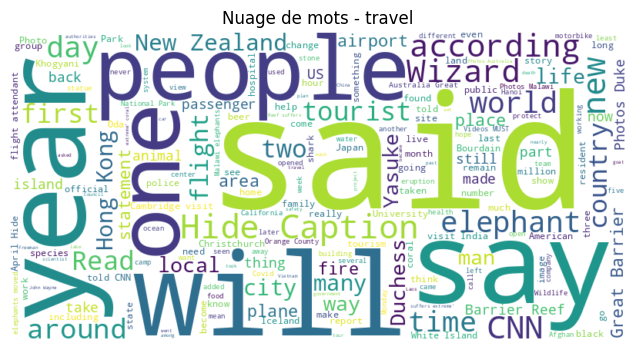

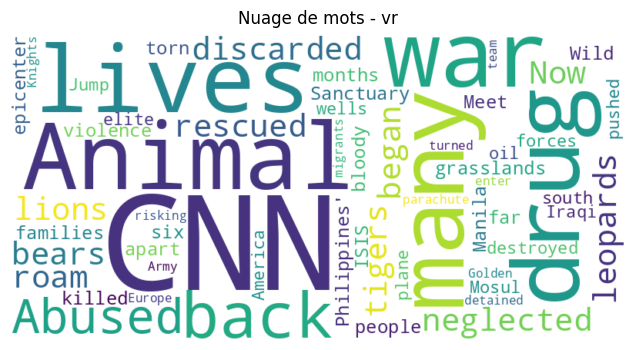

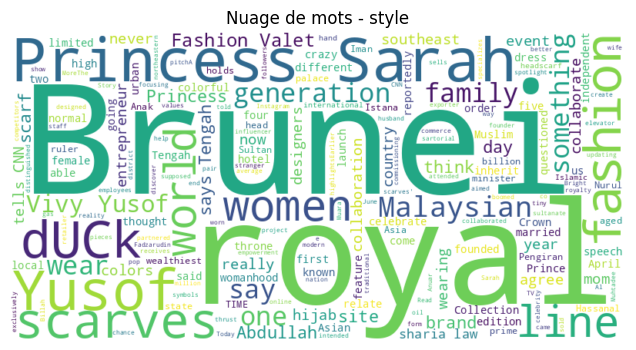

In [ ]:

for category in data['Category'].unique():
    text = " ".join(data[data['Category'] == category]['Article text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nuage de mots - {category}")
    plt.show()


## 5. Visualisation : Répartition des catégories


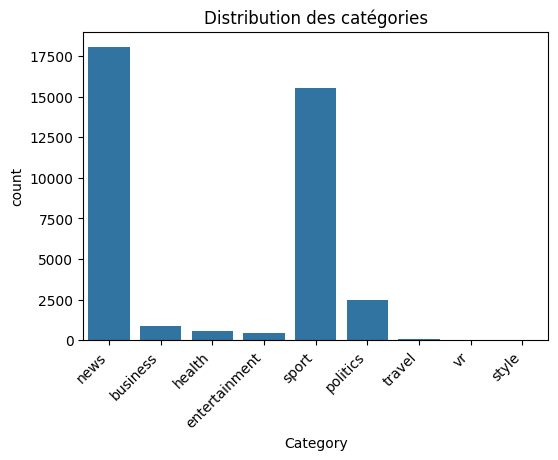

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x="Category")
plt.title("Distribution des catégories")
plt.xticks(rotation=45, ha='right')  # rotation des labels
plt.show()

## 6.Préparation des données

### 1. suppression des categorie 'vr' , 'style' et 'travel'

In [9]:
data = data[~data['Category'].isin(['vr', 'style', 'travel'])]

In [10]:
data['Category'].value_counts()

,count
Category,
news,18076
sport,15544
politics,2467
business,875
health,559
entertainment,418


In [11]:
X = data['Article text']
y= data['Category']

### 2. Divise dataset en donnees d'entrainement et donnees de test:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:", len(X_train))
print("Test:", len(X_test))

Train: 30351
Test: 7588



## 7. Prétraitement du texte : Vectorisation avec TF-IDF


In [13]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# FIT_TRANSFORM sur train (entraîne le vocabulaire)
X_train_vec = tfidf.fit_transform(X_train)

# TRANSFORM sur test (utilise le vocabulaire appris)
X_test_vec = tfidf.transform(X_test)

print(f"Shape X_train_vec: {X_train_vec.shape}")
print(f"Shape X_test_vec: {X_test_vec.shape}")
print(f"Vocabulaire: {len(tfidf.vocabulary_)} mots")

Shape X_train_vec: (30351, 5000)
Shape X_test_vec: (7588, 5000)
Vocabulaire: 5000 mots


## 8. Visualisation de la Vectorisation TF-IDF

In [14]:
articles_messages = [
    X_test.iloc[0], X_test.iloc[1], X_test.iloc[2], X_test.iloc[3]
]

# Transformation des exemples
articles_vec = tfidf.transform(articles_messages)
feature_names = tfidf.get_feature_names_out()


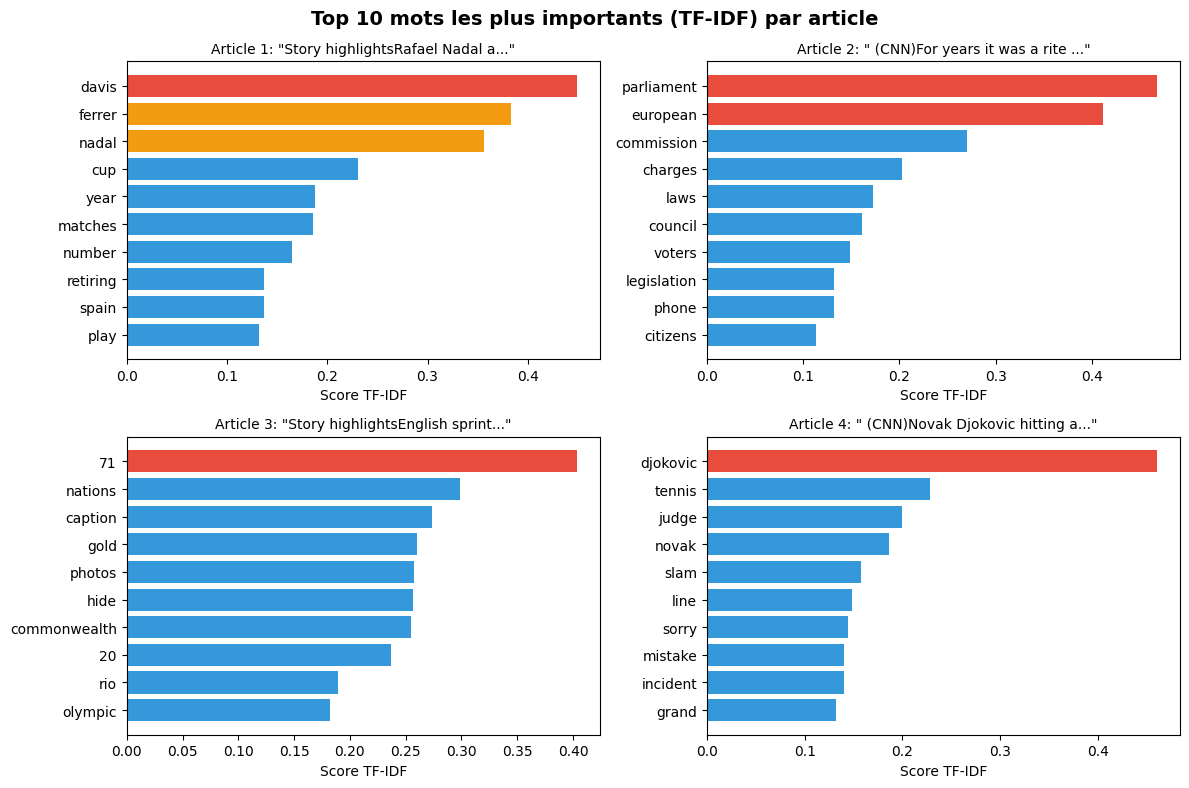

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, article in enumerate(articles_messages):
    vec = articles_vec[i].toarray()[0]
    non_zero_idx = np.where(vec > 0)[0]

    mots = [feature_names[idx] for idx in non_zero_idx]
    scores = [vec[idx] for idx in non_zero_idx]

    # Trier par score décroissant
    sorted_pairs = sorted(zip(mots, scores), key=lambda x: x[1], reverse=True)

    # GARDER SEULEMENT LES 10 PREMIERS
    sorted_pairs = sorted_pairs[:10]

    if sorted_pairs:
        mots, scores = zip(*sorted_pairs)

        colors = ['#e74c3c' if s > 0.4 else '#f39c12' if s > 0.3 else '#3498db' for s in scores]
        axes[i].barh(mots, scores, color=colors)
        axes[i].set_xlabel('Score TF-IDF')
        axes[i].set_title(f'Article {i+1}: "{article[:30]}..."' if len(article) > 30 else f'Article {i+1}: "{article}"', fontsize=10)
        axes[i].invert_yaxis()

plt.suptitle('Top 10 mots les plus importants (TF-IDF) par article', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 9. Entraînement du modèle


In [16]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

## 10. Prédiction et évaluation

In [17]:
y_pred = model.predict(X_test_vec)

### Accuracy:

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy :", accuracy)

Accuracy : 0.9138112809699526


### Rapport de classification

In [19]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     business       0.73      0.55      0.63       167
entertainment       0.69      0.27      0.39        81
       health       0.72      0.39      0.50       135
         news       0.90      0.95      0.92      3622
     politics       0.77      0.74      0.76       464
        sport       0.97      0.96      0.97      3119

     accuracy                           0.91      7588
    macro avg       0.80      0.64      0.69      7588
 weighted avg       0.91      0.91      0.91      7588




### Matrice de confusion


<Figure size 1000x800 with 0 Axes>

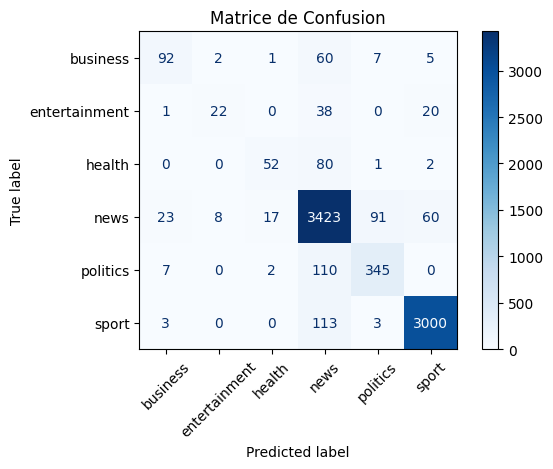

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 1. Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# 2. Afficher la matrice de confusion
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Matrice de Confusion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 11. Sauvegarde et téléchargement du modèle


In [22]:
%cd /content/drive/MyDrive/NLP_project

/content/drive/MyDrive/NLP_project


In [23]:
import joblib

# Sauvegarde du modèle Naive Bayes
joblib.dump(model, "model/naive_bayes_model.pkl")

# Sauvegarde du vectorizer TF-IDF
joblib.dump(tfidf, "model/tfidf_vectorizer.pkl")

print("Modèle Naive Bayes et vectorizer sauvegardés avec succès.")


Modèle Naive Bayes et vectorizer sauvegardés avec succès.


In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Construction du modèle GRU
#### Les réseaux GRU (Gated Recurrent Units) sont adaptés au traitement des séquences textuelles car ils permettent de capturer les dépendances contextuelles entre les mots
#### Ici on a pas utilisee TF-IDF , car  TF-IDF n’est pas adapté aux modèles séquentiels comme les GRU, car il perd l’ordre des mots, alors que les GRU ont justement besoin de l’information séquentielle.

### 1.Prétraitement pour GRU

In [25]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

X = [clean_text(text) for text in X]

In [26]:
# Tokenization
tokenizer_gru = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer_gru.fit_on_texts(data['Article text'])

sequences = tokenizer_gru.texts_to_sequences(data['Article text'])
X = pad_sequences(sequences, maxlen=300, padding='post')

# Labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Category'])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### 2.Modèle GRU

In [27]:
num_classes = len(set(y))

model_gru = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=300),
    GRU(64, kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# model_gru.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### 3.Entraînement du GRU

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [29]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 229s 263ms/step - accuracy: 0.6476 - loss: 1.0206 - val_accuracy: 0.8752 - val_loss: 0.4517
Epoch 2/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 258s 259ms/step - accuracy: 0.8924 - loss: 0.4028 - val_accuracy: 0.8992 - val_loss: 0.3646
Epoch 3/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 228s 219ms/step - accuracy: 0.9179 - loss: 0.2869 - val_accuracy: 0.9022 - val_loss: 0.3426
Epoch 4/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 184s 216ms/step - accuracy: 0.9337 - loss: 0.2191 - val_accuracy: 0.8986 - val_loss: 0.3446
Epoch 5/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 185s 217ms/step - accuracy: 0.9455 - loss: 0.1771 - val_accuracy: 0.8959 - val_loss: 0.3735


### 4.Évaluation du modèle GRU

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

y_pred_gru = np.argmax(model_gru.predict(X_test), axis=1)

print("Accuracy GRU:", accuracy_score(y_test, y_pred_gru))
print(classification_report(y_test, y_pred_gru, target_names=encoder.classes_))

238/238 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step
Accuracy GRU: 0.9031365313653137
               precision    recall  f1-score   support

     business       0.43      0.02      0.03       167
entertainment       0.00      0.00      0.00        81
       health       0.00      0.00      0.00       135
         news       0.90      0.95      0.92      3622
     politics       0.63      0.84      0.72       464
        sport       0.96      0.97      0.97      3119

     accuracy                           0.90      7588
    macro avg       0.49      0.46      0.44      7588
 weighted avg       0.87      0.90      0.88      7588



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 5.Visualisation Accuracy & Loss (GRU)

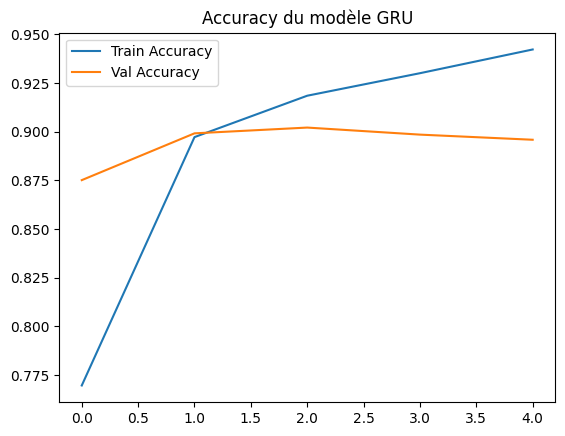

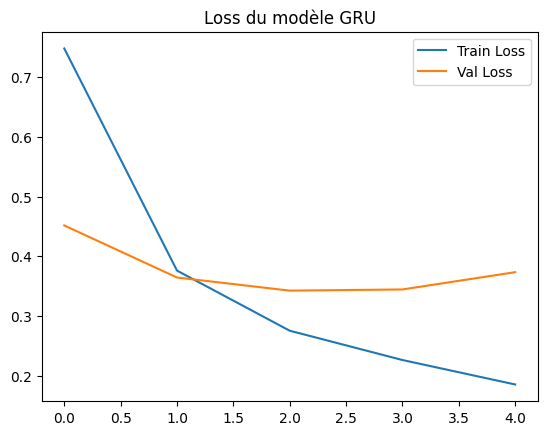

In [31]:
# Accuracy
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy du modèle GRU")
plt.legend()
plt.show()

# Loss
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title("Loss du modèle GRU")
plt.legend()
plt.show()

### 6.Sauvegarde du modèle GRU

In [32]:
# Sauvegarde du modèle
model_gru.save("gru_news_model.h5")

# Sauvegarde du tokenizer
import pickle
with open("tokenizer_gru.pkl", "wb") as f:
    pickle.dump(tokenizer_gru, f)

# Sauvegarde du label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)

print("Modèle GRU sauvegardé avec succès")

Modèle GRU sauvegardé avec succès
